# Distance from male X haplotypes to archaic pseudohaploids

In [1]:
import re, os, sys, pickle, pickle
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from ChromosomeWindows import window
import genominterv

#from HorizonPlot import horizon_plot

numpy.random.seed(7)

Plotting setup:

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("whitegrid")
sns.set_context("paper")

def stairs(df, start='start', end='end', pos='pos'):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end]
    return pandas.concat([df1, df2]).sort_values([start, end])

Ignore deprecation warnings from mainly seaborn:

In [3]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

Import variables global to the entire analysis:

In [4]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [5]:
scripts_dir = ag.root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

## Load meta data

In [6]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=ag.meta_data_dir)

pop_categories = pandas.read_hdf(str(ag.results_dir / 'population_categories.store'), 'sr')
region_categories = pandas.read_hdf(str(ag.results_dir / 'region_categories.store'), 'sr')

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Read in distances to archaics for each individual

In [7]:
all_male_dist_to_archaic = pandas.read_hdf(str(ag.steps_dir / 'archaic_dist_stores/archaic_dist_data_chrX_100kb.hdf'))                        
all_male_dist_to_archaic.head()

,chrom,start,end,pop_label,indiv_1,pseud_1,indiv_2,pseud_2,dist,mismatch,match,uncalled,region_label_1,region_id_1,region_1
142600,X,0,100000,NA,B_Dinka-3,A,Altai,A,0.000000,0,281,99719,Africa,0,Africa
480500,X,0,100000,NA,B_Dinka-3,A,Denisova,B,0.006897,2,288,99710,Africa,0,Africa
491350,X,0,100000,NA,B_Dinka-3,A,Denisova,A,0.003448,1,289,99710,Africa,0,Africa
558000,X,0,100000,NA,B_Dinka-3,A,Altai,B,0.000000,0,281,99719,Africa,0,Africa
142601,X,100000,200000,NA,B_Dinka-3,A,Altai,A,0.003916,12,3052,96936,Africa,0,Africa


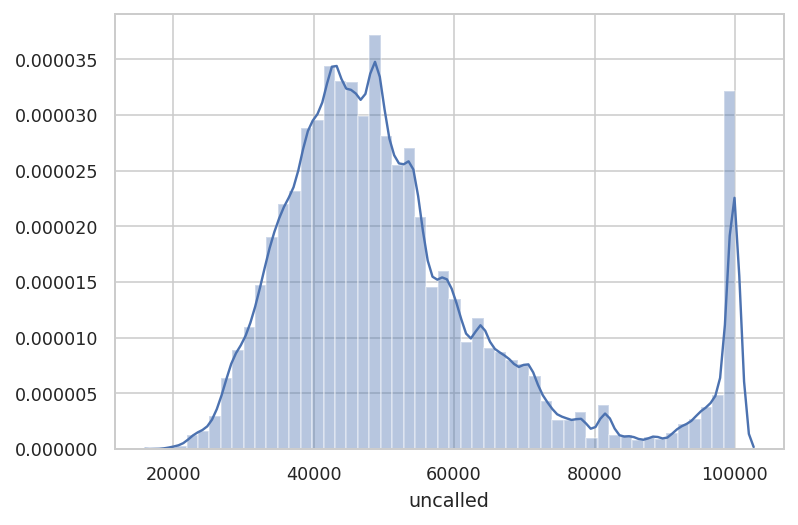

In [8]:
sns.distplot(all_male_dist_to_archaic.uncalled) ;

Filter and compute mean over the two psudohaplotypes for each archaic:

In [ ]:
male_dist_to_archaic_filt = (all_male_dist_to_archaic.loc[all_male_dist_to_archaic.uncalled < 70000]
                             .reset_index(drop=True)
                             .groupby(['chrom', 'start', 'end', 'indiv_1', 'indiv_2', 'pop_label', 'region_label_1'])
                             .mean()
                             .reset_index()
                            )
male_dist_to_archaic_filt.head()

Distribution of uncalled bases:

Filter for coverage:

In [ ]:
male_dist_to_archaic_filt.groupby('indiv_2').describe()

## Distribution of distance across windows

In [ ]:
g = sns.distplot(male_dist_to_archaic_filt.loc[male_dist_to_archaic_filt.indiv_2 == 'Altai'].dist.dropna())
g = sns.distplot(male_dist_to_archaic_filt.loc[male_dist_to_archaic_filt.indiv_2 == 'Denisova'].dist.dropna())
plt.show()

In [ ]:
# plt.close()
# fig = horizon_plot(df.loc[df.indiv_2 == 'Denisova'].assign(chrom='X'), 'dist',
#              width=100000, row='indiv_1', col='chrom', size=0.3, aspect=30)


In [ ]:
# plt.close()
# fig = horizon_plot(df.loc[df.indiv_2 == 'Altai'].assign(chrom='X'), 'dist',
#              width=100000, row='indiv_1', col='chrom', size=0.3, aspect=30)


In [ ]:
# with sns.axes_style('dark'):
#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5))
#     ax1.bar(df.loc[(df.indiv_2 == 'Altai') & (df.indiv_1 == 'S_English-1')].start,
#             df.loc[(df.indiv_2 == 'Altai') & (df.indiv_1 == 'S_English-1')].dist, width=100000)
#     ax2.bar(df.loc[(df.indiv_2 == 'Denisova') & (df.indiv_1 == 'S_English-1')].start,
#             df.loc[(df.indiv_2 == 'Denisova') & (df.indiv_1 == 'S_English-1')].dist, width=100000)
#     #plt.ylim(0, 0.0005)

In [ ]:
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5))
# ax1.bar(df.loc[(df.indiv_2 == 'Altai') & (df.indiv_1 == 'S_Papuan-8')].start,
#         df.loc[(df.indiv_2 == 'Altai') & (df.indiv_1 == 'S_Papuan-8')].dist, width=100000)
# ax2.bar(df.loc[(df.indiv_2 == 'Denisova') & (df.indiv_1 == 'S_Papuan-8')].start,
#         df.loc[(df.indiv_2 == 'Denisova') & (df.indiv_1 == 'S_Papuan-8')].dist, width=100000)
# #plt.ylim(0, 0.0005)

In [ ]:
with sns.plotting_context('notebook', font_scale=0.5):
    plt.figure(figsize=(20, 20))
    sns.heatmap(male_dist_to_archaic_filt.loc[male_dist_to_archaic_filt.indiv_2 == 'Altai', ['indiv_1', 'start', 'dist']]
                .pivot('indiv_1', 'start', 'dist'), cmap="YlGnBu")
    

In [ ]:
with sns.plotting_context('notebook', font_scale=0.5):
    plt.figure(figsize=(20, 20))
    sns.heatmap(male_dist_to_archaic_filt.loc[male_dist_to_archaic_filt.indiv_2 == 'Denisova', ['indiv_1', 'start', 'dist']]
                .pivot('indiv_1', 'start', 'dist'), cmap="YlGnBu")

In [ ]:
with sns.plotting_context('notebook', font_scale=0.5):
    fig, axes = plt.subplots(7, 1, figsize=(25,20), sharex=True)
    for i, region in enumerate(['Africa', 'WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 
                                'Oceania', 'EastAsia', 'America']):
        sns.heatmap(male_dist_to_archaic_filt.loc[(male_dist_to_archaic_filt.indiv_2 == 'Altai') & \
                                                  (male_dist_to_archaic_filt.region_label_1 == region)]
                    .pivot('indiv_1', 'start', 'dist'), ax=axes[i], cmap="YlGnBu")
        axes[i].set_title(region)

In [ ]:
with sns.plotting_context('notebook', font_scale=0.5):
    fig, axes = plt.subplots(7, 1, figsize=(25,20), sharex=True)
    for i, region in enumerate(['Africa', 'WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 
                                'Oceania', 'EastAsia', 'America']):
        sns.heatmap(male_dist_to_archaic_filt.loc[(male_dist_to_archaic_filt.indiv_2 == 'Denisova') & \
                                                  (male_dist_to_archaic_filt.region_label_1 == region)]
                    .pivot('indiv_1', 'start', 'dist'), ax=axes[i], cmap="YlGnBu")
        axes[i].set_title(region)

In [ ]:
extended_peak_regions_10 = pandas.read_hdf(ag.results_dir / 'extended_peak_regions_10%.hdf')
human_chimp_low_ils_regions_chrX = pandas.read_hdf(ag.results_dir / 'human_chimp_low_ils_regions_chrX.hdf')
ampliconic_regions = pandas.read_hdf(ag.results_dir / 'ampliconic_regions.hdf')

plot_df = stairs(male_dist_to_archaic_filt.groupby(['start', 'indiv_2']).mean().reset_index())
with sns.color_palette('colorblind'):
    with sns.axes_style('ticks'):
        fig, ax = plt.subplots(1, 1, figsize=(25,10))
        plt.semilogy(plot_df.loc[plot_df.indiv_2 == 'Altai'].pos, 
                     plot_df.loc[plot_df.indiv_2 == 'Altai'].dist, label='Altai', alpha=0.5)
        plt.semilogy(plot_df.loc[plot_df.indiv_2 == 'Denisova'].pos, 
                     plot_df.loc[plot_df.indiv_2 == 'Denisova'].dist, label='Denisova', alpha=0.5)
        
        for tup in extended_peak_regions_10.itertuples():
            g = ax.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                     facecolor='lightgray', 
                     linewidth=0,
        #              edgecolor=None,
                     alpha=0.5,
                     zorder=1))

        for tup in human_chimp_low_ils_regions_chrX.itertuples():
            g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                         facecolor='lightblue',
                         linewidth=0,
                         alpha=0.3,
                         zorder=0))
            
        for tup in ampliconic_regions.itertuples():
            g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                         facecolor='pink',
                         linewidth=0,
                         alpha=1,
                         zorder=0))           

In [ ]:
extended_peak_regions_90 = pandas.read_hdf(ag.results_dir / 'extended_peak_regions_90%.hdf')

plot_df = stairs(male_dist_to_archaic_filt.groupby(['start', 'indiv_2']).mean().reset_index())
with sns.color_palette('colorblind'):
    with sns.axes_style('ticks'):
        fig, ax = plt.subplots(1, 1, figsize=(25,10))
        plt.semilogy(plot_df.loc[plot_df.indiv_2 == 'Altai'].pos, 
                     plot_df.loc[plot_df.indiv_2 == 'Altai'].dist, label='Altai', alpha=0.5)
        plt.semilogy(plot_df.loc[plot_df.indiv_2 == 'Denisova'].pos, 
                     plot_df.loc[plot_df.indiv_2 == 'Denisova'].dist, label='Denisova', alpha=0.5)
        
        for tup in extended_peak_regions_90.itertuples():
            g = ax.add_patch(Rectangle((tup.start_pos, -1), tup.end_pos-tup.start_pos, 2, 
                 facecolor='lightgray', 
                 linewidth=0,
        #              edgecolor=None,
                 alpha=0.5,
                 zorder=1))

In [ ]:
sweep_data = pandas.read_hdf(ag.results_dir / 'sweep_data.hdf')

merged_data = (sweep_data.merge(male_dist_to_archaic_filt, how='left',
                                on=['indiv_1', 'start', 'end'])
               .loc[lambda df: df.not_missing == True] # only windows where enough individuals are called
              )
merged_data.head()

## Distance to Archiacs in swept and non-swept regions

In [ ]:
with sns.color_palette('colorblind'):
    with sns.plotting_context('paper', font_scale=1.2):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
            g1 = sns.barplot(x="not_never_swept", y="dist", hue='indiv_2',
                             data=merged_data.assign(not_never_swept=~merged_data.never_swept), ax=ax1)
            g1 = sns.boxplot(x="not_never_swept", y="dist", hue='indiv_2',
                             data=merged_data.assign(not_never_swept=~merged_data.never_swept), ax=ax2)
            ax1.get_legend().set_visible(False)
            ax2.legend(bbox_to_anchor=(1.1, 1.0))
            plt.tight_layout()

## Distance to Archiacs in swept and non-swept haplotypes in swept regions

In [ ]:
plot_df = (merged_data.loc[lambda df: (df.partial_sweep_win == True),# & (df.conserv_swept_group != 'ambig'),
                          ['indiv_1', 'indiv_2', 'region_1', 'start', 'swept', 'dist']]
      
                  # removing 'ambig' creates windows that does not have both swept and non-swept
                  # so we need to filter to get only windows that include both calls:
                  .groupby(['start']).filter(lambda df: set(df['swept']) == set([False, True]))
      
           .melt(id_vars=['indiv_1', 'indiv_2', 'region_1', 'start', 'dist'], 
                 value_vars=['swept'], 
                 var_name='call',
                value_name='is_swept')
          )

plot_df['region_1'] = plot_df.region_1.astype('category').cat.set_categories(
    ['Africa', 'WestEurasia', 'SouthAsia', 'CentralAsiaSiberia', 'Oceania', 'EastAsia', 'America'])

plot_df = plot_df.loc[lambda df: df.region_1 != 'Africa']


# plot_df['region_1'] 
plot_df['region_1'] = plot_df.region_1.cat.remove_unused_categories()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

with sns.color_palette('colorblind'):
    with sns.axes_style('ticks'):
        with sns.plotting_context('paper', font_scale=1.2):
#             g = sns.barplot(x='call', y='dist', hue='is_swept', data=plot_df)
#             g = sns.boxplot(x='call', y='dist', hue='is_swept', data=plot_df)
#             g.set_yscale("log")
            g = sns.violinplot(x='is_swept', y='dist', data=plot_df, ax=ax1)
#             g = sns.swarmplot(x='is_swept', y='dist', data=plot_df)

            g = sns.stripplot(x='is_swept', y='dist', hue='indiv_2', dodge=True, jitter=True, alpha=0.1, data=plot_df, ax=ax2)            
            g.set_yscale('log')

            g.legend(loc='lower right')
        
#             g.set_ylim(0.00001, 0.01)

In [ ]:
plot_df.loc[plot_df.dist < 1e-4]